In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (623).jpg
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (421).jpg
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (301).jpg
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (401).png
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (599).jpg
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (257).jpg
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (5).jpg
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (166).png
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (206).jpg
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (551).jpg
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (452).jpg
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (438).jpg
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (711).jpg
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (9).jpg
/kaggle/input/vehicle-classification/Vehicles/Ships/Ship (96).jpg


In [2]:
img_path = "/kaggle/input/vehicle-classification/Vehicles"

In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

In [4]:
from tqdm.notebook import tqdm

In [5]:
class Vehicle_Dataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform = transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

    

In [6]:
target_to_class ={}

for v,k in ImageFolder(img_path).class_to_idx.items():
    target_to_class[k] = v

In [7]:
target_to_class

{0: 'Auto Rickshaws',
 1: 'Bikes',
 2: 'Cars',
 3: 'Motorcycles',
 4: 'Planes',
 5: 'Ships',
 6: 'Trains'}

In [8]:
import timm

In [9]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [10]:
dataset = Vehicle_Dataset("/kaggle/input/vehicle-classification/Vehicles", transform = transform)

In [11]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

In [12]:
def load_model():
    model = timm.create_model('efficientnet_b0', pretrained = True)
    model = nn.Sequential(
    *list(model.children())[:-1],
    nn.Linear(1280,7))
    #print(model)
    return model

In [13]:
model = load_model()

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [14]:
def return_loader(dataset,batch_size):
    return DataLoader(
    dataset,
    batch_size = batch_size,
    shuffle=True,
    )

In [15]:
import shutil
main_dir = "/kaggle/input/vehicle-classification/Vehicles"
categories = ["Auto Rickshaws", "Bikes", "Cars", "Motorcycles", "Planes", "Ships", "Trains"]

split_dirs = ["train", "val", "test"]
base_split_dir = "/kaggle/working/vehicles_split"

for split_dir in split_dirs:
    for category in categories:
        os.makedirs(os.path.join(base_split_dir, split_dir, category), exist_ok=True)
        
for category in categories:
    category_path = os.path.join(main_dir, category)
    images = os.listdir(category_path)
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    def move_images(image_list, destination):
        for image in image_list:
            shutil.copy(os.path.join(category_path, image), os.path.join(base_split_dir, destination, category, image))

    move_images(train_images, "train")
    move_images(val_images, "val")
    move_images(test_images, "test")

In [16]:
train_dataset = Vehicle_Dataset("/kaggle/working/vehicles_split/train", transform = transform)
val_dataset = Vehicle_Dataset("/kaggle/working/vehicles_split/val", transform = transform)
model = load_model()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [17]:
train_loader = return_loader(train_dataset,64)
valid_loader = return_loader(val_dataset,64)

In [18]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [19]:
max_epochs = 20
save_every = 5
training_losses = []
valid_losses = []
model.to(device)
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc= "Training Loop"):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
    
    train_loss = running_loss/len(train_loader)
    training_losses.append(train_loss)
    
    model.eval()
    runnning_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc= "Validation Loop"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            running_loss += loss.item() * labels.size(0)
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss)
    
    
    print(f"Epoch :{epoch+1}  | Training_Loss :{train_loss}  | Validation loss :{valid_loss}")
    if(epoch%save_every == 0):
        chk = model.state_dict()
        torch.save(chk, "/kaggle/working/Checkpoint.pt")
        print(f"Epochs :{epoch+1} | Training saved successfully! ")

Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch :1  | Training_Loss :15.641247138861686  | Validation loss :78.03328149233546
Epochs :1 | Training saved successfully! 


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :2  | Training_Loss :5.622639020844813  | Validation loss :29.679313158017717


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :3  | Training_Loss :1.441792953819517  | Validation loss :9.702211447924908


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :4  | Training_Loss :0.8387021251593626  | Validation loss :8.215869449760898


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :5  | Training_Loss :1.1241409513618676  | Validation loss :12.40190273902512


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :6  | Training_Loss :2.02190120782583  | Validation loss :15.273485808766313
Epochs :6 | Training saved successfully! 


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :7  | Training_Loss :1.5266928040692884  | Validation loss :15.068222289541675


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :8  | Training_Loss :5.852874934312798  | Validation loss :33.779633817396


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :9  | Training_Loss :4.16876591147194  | Validation loss :37.121336684030084


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :10  | Training_Loss :3.850032865400276  | Validation loss :23.786506431975535


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :11  | Training_Loss :0.8372526613755091  | Validation loss :9.573094629761597
Epochs :11 | Training saved successfully! 


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :12  | Training_Loss :0.9361207935989143  | Validation loss :9.763839448733572


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :13  | Training_Loss :0.4592783321821762  | Validation loss :7.096750002420906


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :14  | Training_Loss :0.731949650682509  | Validation loss :7.955060470178361


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :15  | Training_Loss :1.0829627181012784  | Validation loss :11.176158845100352


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :16  | Training_Loss :3.1704438311280683  | Validation loss :29.474448896129616
Epochs :16 | Training saved successfully! 


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :17  | Training_Loss :1.6987379282682893  | Validation loss :14.859753281609821


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :18  | Training_Loss :0.5164209648275808  | Validation loss :9.142628488962405


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :19  | Training_Loss :5.866492323337063  | Validation loss :32.928874209485784


Training Loop:   0%|          | 0/62 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch :20  | Training_Loss :0.7226000900770868  | Validation loss :6.860300846397877


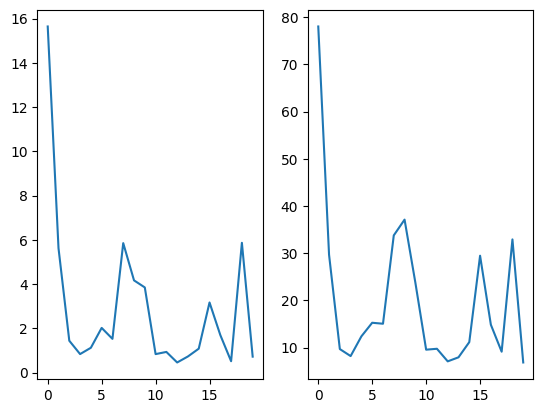

In [20]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1,2)
axis[0].plot(training_losses)

axis[1].plot(valid_losses)
plt.show()

In [21]:
test_dataset = Vehicle_Dataset("/kaggle/working/vehicles_split/test", transform = transform)
test_loader = return_loader(test_dataset, 64)

In [23]:
def compute_accuracy(outputs, labels):
    return np.mean(outputs == labels)

In [24]:
accuracies= []
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        output = output.detach().cpu().numpy()
        output = np.argmax(output, axis = 1)
        labels = labels.detach().cpu().numpy()
        accuracy = compute_accuracy(output, labels)
        accuracies.append(accuracy)

  0%|          | 0/14 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [25]:
accuracy_avg = sum(accuracies)/len(accuracies)

In [26]:
print(f"Accuracy for test set is : {accuracy_avg *100} %")

Accuracy for test set is : 98.88392857142857 %
